<a href="https://colab.research.google.com/github/jimmyshah83/deep_learning/blob/master/GAN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN Using Keras

In [0]:
#import tensorflow as tf
#tf.enable_eager_execution()

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
from __future__ import absolute_import, division, print_function

In [0]:
import os
import time
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers

%matplotlib inline

Image size used as 24 as training was taking a long time for an Image f size 128. Model adjusted accordingly

In [0]:
# Hyperparameters
IMAGE_SIZE = 64
NOISE_SIZE = 100
BATCH_SIZE = 128
EPOCHS = 100
BETA1 = 0.5
EPSILON = 0.00005
BUFFER_SIZE = 9000
LR_D = 0.00004
LR_G = 0.0004

In [0]:
train_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) 
                           for file in glob('drive/My Drive/images/' + '10*.png')])

In [84]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print ("Input: " + str(train_images.shape))

Input: (111, 64, 64, 3)


In [0]:
train_images = train_images.astype('float32')

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_dataset = get_batches(train_images)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024)
    
    model.add(layers.Conv2DTranspose(512, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), padding='same', use_bias=False))
    
    return model

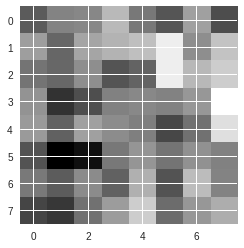

In [88]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  
  model.add(layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2D(64, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
    
  model.add(layers.Conv2D(128, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
    
  model.add(layers.Conv2D(256, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Conv2D(512, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Conv2D(1024, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
              
  return model

In [90]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
decision.shape

tf.Tensor([[0.49999994]], shape=(1, 1), dtype=float32)


TensorShape([Dimension(1), Dimension(1)])

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
discriminator_optimizer = optimizers.Adam(lr=LR_D, beta_1=BETA1)
generator_optimizer = optimizers.Adam(lr=LR_G, beta_1=BETA1)

In [0]:
seed = tf.random.normal([16, 100])

In [0]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
    
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

In [0]:
def train(dataset):  
  for epoch in range(EPOCHS):
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)
      
    # Produce images for the GIF as we go
    generate_images(generator, epoch + 1, seed)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [0]:
def generate_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

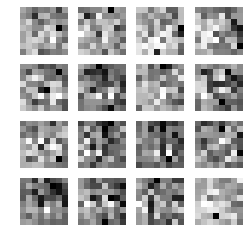

Time for epoch 1 is 1.655123233795166 sec


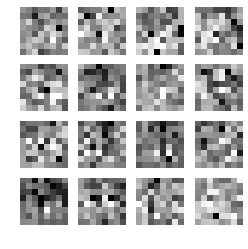

Time for epoch 2 is 1.538808822631836 sec


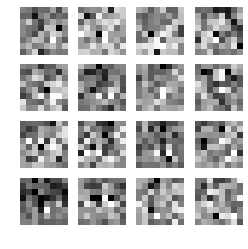

Time for epoch 3 is 1.5499646663665771 sec


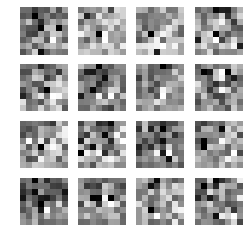

Time for epoch 4 is 1.7645173072814941 sec


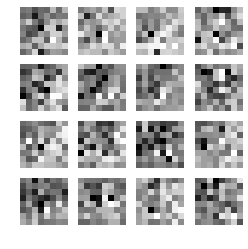

Time for epoch 5 is 1.5315611362457275 sec


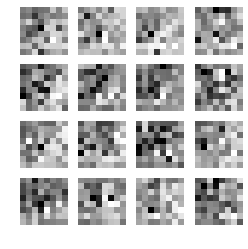

Time for epoch 6 is 1.550407886505127 sec


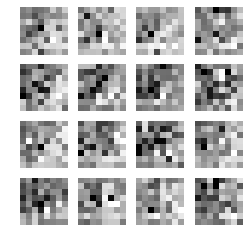

Time for epoch 7 is 1.5298974514007568 sec


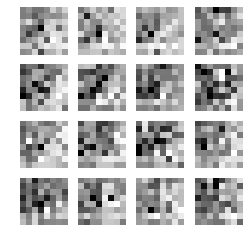

Time for epoch 8 is 1.5493338108062744 sec


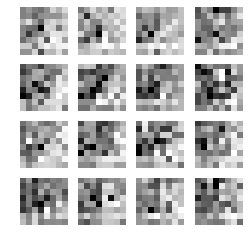

Time for epoch 9 is 1.786607027053833 sec


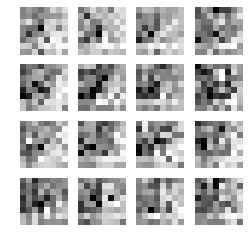

Time for epoch 10 is 1.5431580543518066 sec


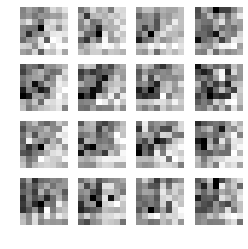

Time for epoch 11 is 1.540013313293457 sec


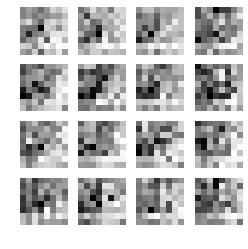

Time for epoch 12 is 1.5416216850280762 sec


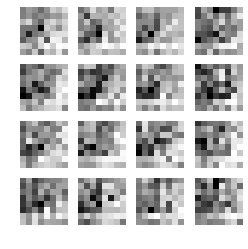

Time for epoch 13 is 1.7714273929595947 sec


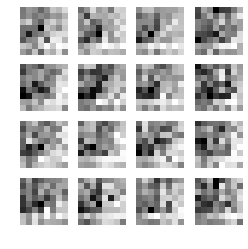

Time for epoch 14 is 1.5355291366577148 sec


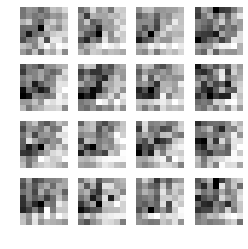

Time for epoch 15 is 1.5468535423278809 sec


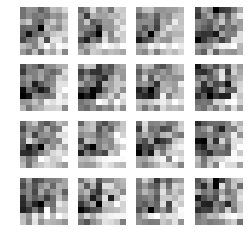

Time for epoch 16 is 1.5235509872436523 sec


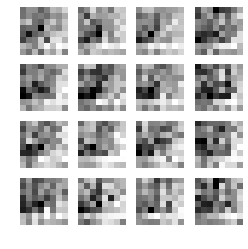

Time for epoch 17 is 1.8134052753448486 sec


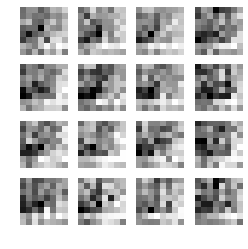

Time for epoch 18 is 1.5692505836486816 sec


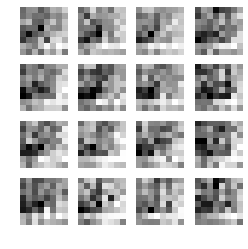

Time for epoch 19 is 1.5482709407806396 sec


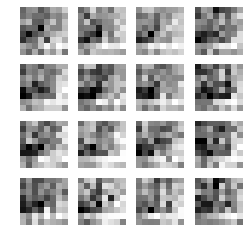

Time for epoch 20 is 1.5502560138702393 sec


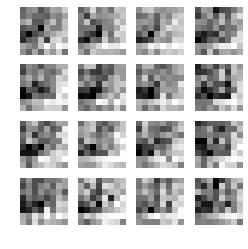

Time for epoch 21 is 1.5410473346710205 sec


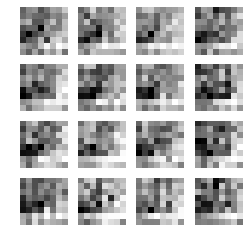

Time for epoch 22 is 1.7655541896820068 sec


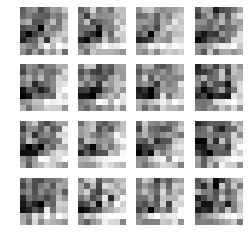

Time for epoch 23 is 1.5399560928344727 sec


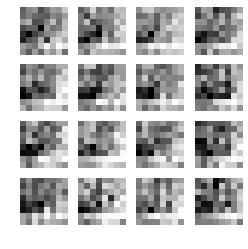

Time for epoch 24 is 1.5373713970184326 sec


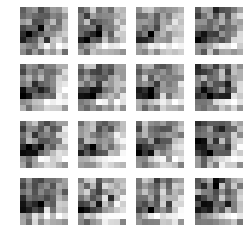

Time for epoch 25 is 1.521613359451294 sec


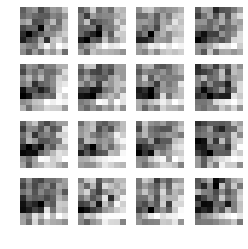

Time for epoch 26 is 1.7786388397216797 sec


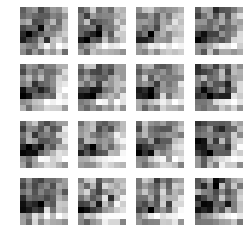

Time for epoch 27 is 1.5557572841644287 sec


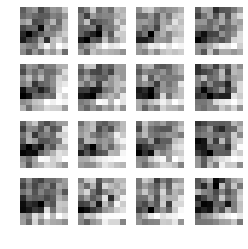

Time for epoch 28 is 1.5327835083007812 sec


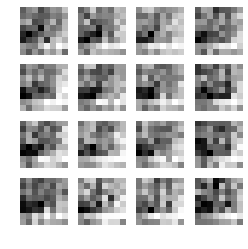

Time for epoch 29 is 1.563124418258667 sec


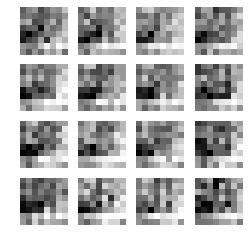

Time for epoch 30 is 1.8051495552062988 sec


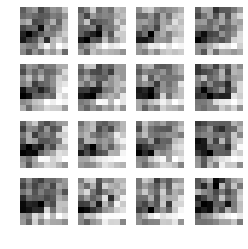

Time for epoch 31 is 1.558980941772461 sec


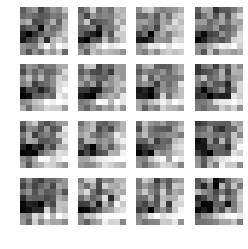

Time for epoch 32 is 1.534623146057129 sec


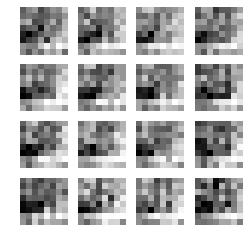

Time for epoch 33 is 1.560417890548706 sec


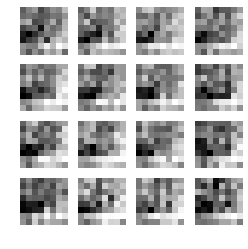

Time for epoch 34 is 1.5400471687316895 sec


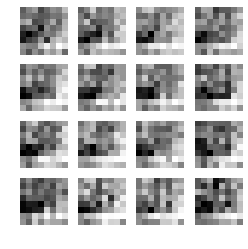

Time for epoch 35 is 1.810718059539795 sec


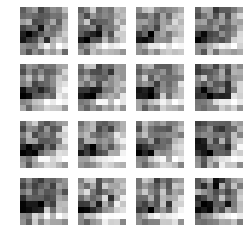

Time for epoch 36 is 1.5514857769012451 sec


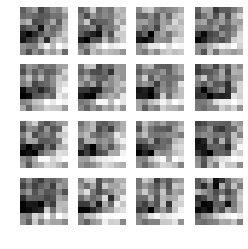

Time for epoch 37 is 1.5242609977722168 sec


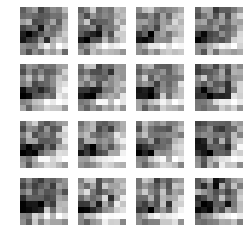

Time for epoch 38 is 1.5450048446655273 sec


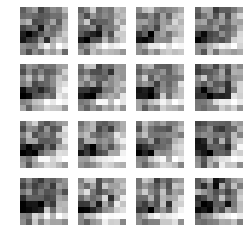

Time for epoch 39 is 1.768017053604126 sec


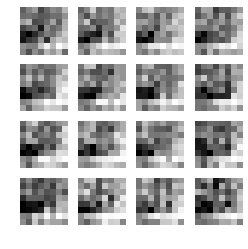

Time for epoch 40 is 1.5578992366790771 sec


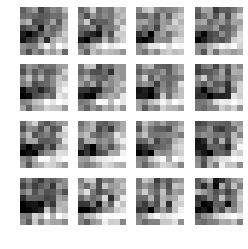

Time for epoch 41 is 1.532088041305542 sec


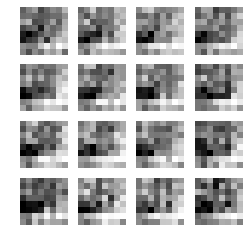

Time for epoch 42 is 1.5293948650360107 sec


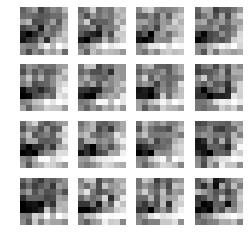

Time for epoch 43 is 1.8098483085632324 sec


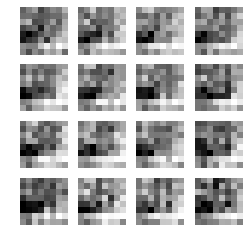

Time for epoch 44 is 1.5441129207611084 sec


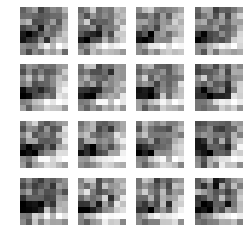

Time for epoch 45 is 1.5600571632385254 sec


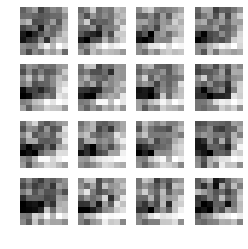

Time for epoch 46 is 1.5514376163482666 sec


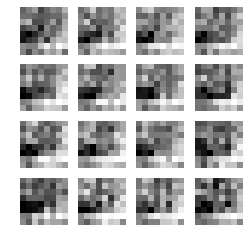

Time for epoch 47 is 1.5559780597686768 sec


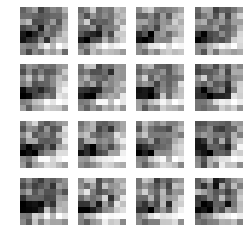

Time for epoch 48 is 1.7687361240386963 sec


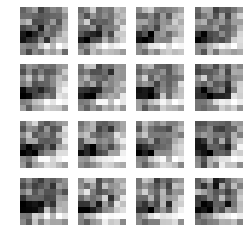

Time for epoch 49 is 1.535689353942871 sec


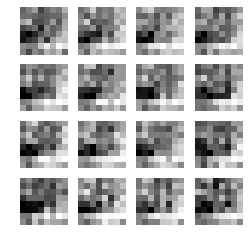

Time for epoch 50 is 1.5368125438690186 sec


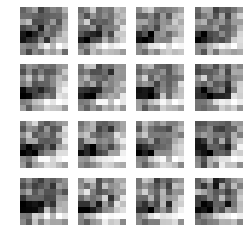

Time for epoch 51 is 1.562187910079956 sec


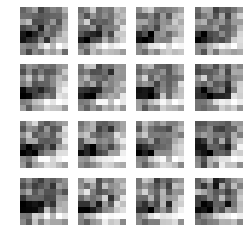

Time for epoch 52 is 1.7492682933807373 sec


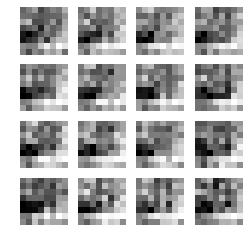

Time for epoch 53 is 1.5440349578857422 sec


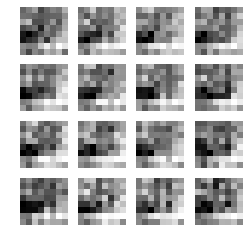

Time for epoch 54 is 1.5457518100738525 sec


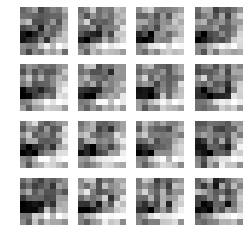

Time for epoch 55 is 1.558521032333374 sec


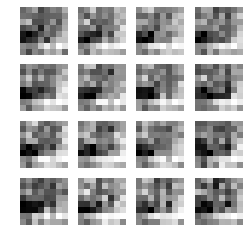

Time for epoch 56 is 1.7906582355499268 sec


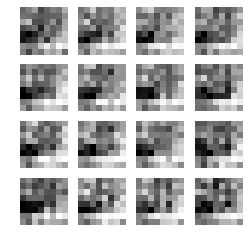

Time for epoch 57 is 1.5358898639678955 sec


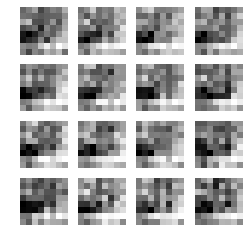

Time for epoch 58 is 1.5342564582824707 sec


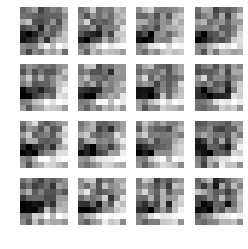

Time for epoch 59 is 1.54646897315979 sec


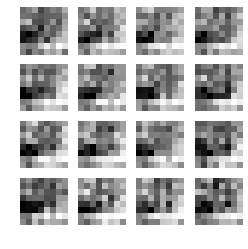

Time for epoch 60 is 1.5516927242279053 sec


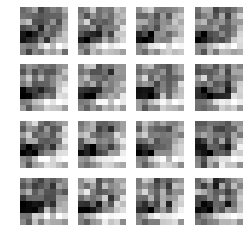

Time for epoch 61 is 1.799687147140503 sec


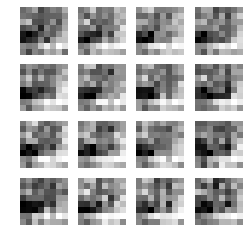

Time for epoch 62 is 1.536482810974121 sec


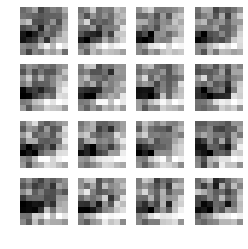

Time for epoch 63 is 1.5554144382476807 sec


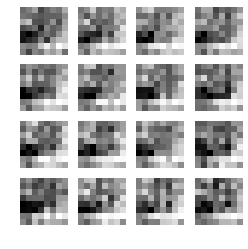

Time for epoch 64 is 1.5449843406677246 sec


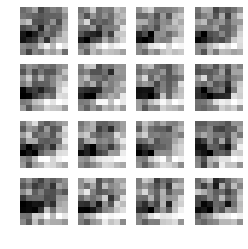

Time for epoch 65 is 1.767202377319336 sec


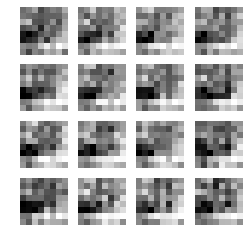

Time for epoch 66 is 1.521817922592163 sec


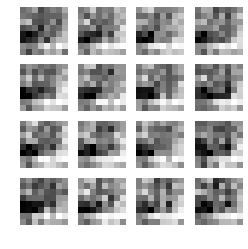

Time for epoch 67 is 1.5615642070770264 sec


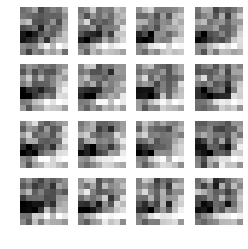

Time for epoch 68 is 1.552452564239502 sec


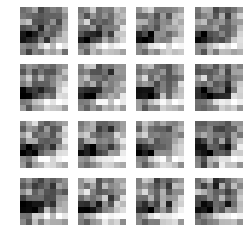

Time for epoch 69 is 1.8090946674346924 sec


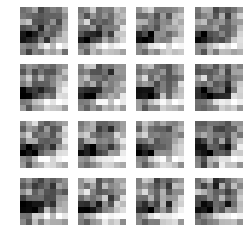

Time for epoch 70 is 1.5634396076202393 sec


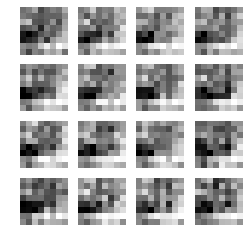

Time for epoch 71 is 1.5496413707733154 sec


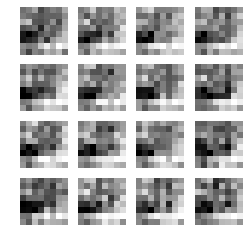

Time for epoch 72 is 1.5426387786865234 sec


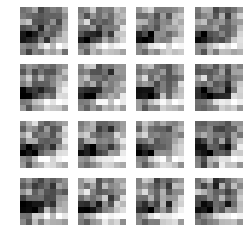

Time for epoch 73 is 1.5409674644470215 sec


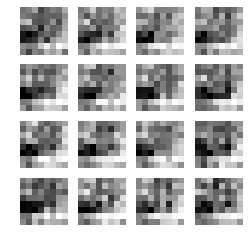

Time for epoch 74 is 1.787804365158081 sec


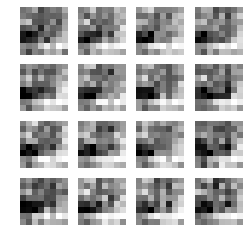

Time for epoch 75 is 1.5573060512542725 sec


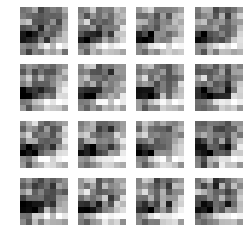

Time for epoch 76 is 1.5449001789093018 sec


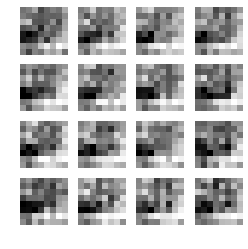

Time for epoch 77 is 1.5585510730743408 sec


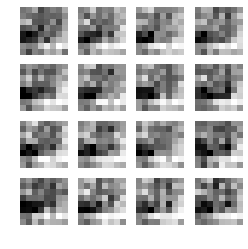

Time for epoch 78 is 1.802868366241455 sec


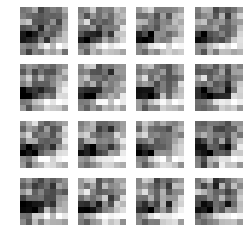

Time for epoch 79 is 1.5650670528411865 sec


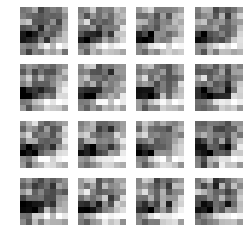

Time for epoch 80 is 1.5490317344665527 sec


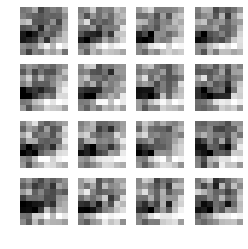

Time for epoch 81 is 1.5555472373962402 sec


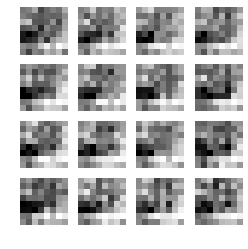

Time for epoch 82 is 1.8163175582885742 sec


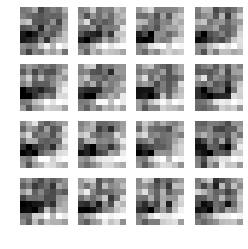

Time for epoch 83 is 1.558091402053833 sec


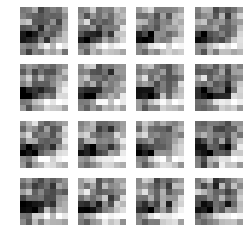

Time for epoch 84 is 1.5464603900909424 sec


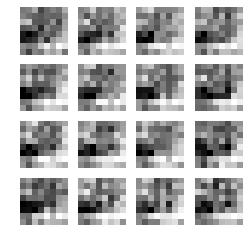

Time for epoch 85 is 1.5509061813354492 sec


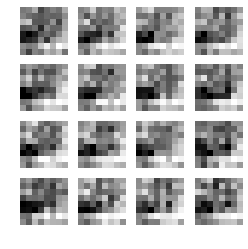

Time for epoch 86 is 1.5586228370666504 sec


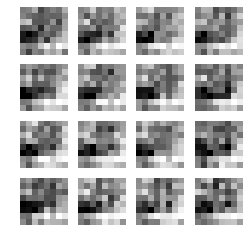

Time for epoch 87 is 1.8023872375488281 sec


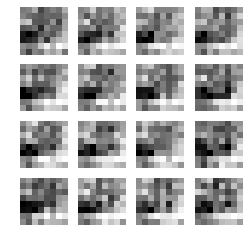

Time for epoch 88 is 1.5672705173492432 sec


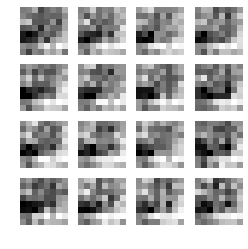

Time for epoch 89 is 1.5587666034698486 sec


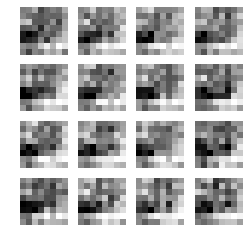

Time for epoch 90 is 1.5600016117095947 sec


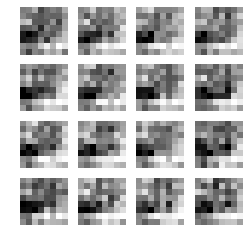

Time for epoch 91 is 1.794351577758789 sec


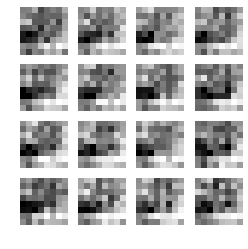

Time for epoch 92 is 1.5378148555755615 sec


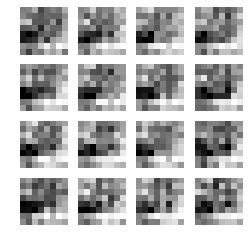

Time for epoch 93 is 1.5589158535003662 sec


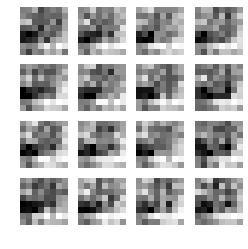

Time for epoch 94 is 1.553614854812622 sec


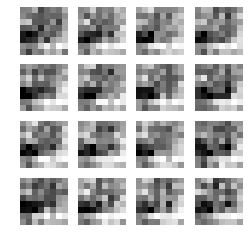

Time for epoch 95 is 1.8115108013153076 sec


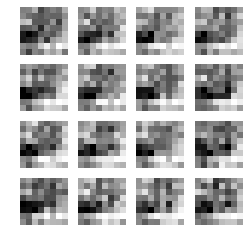

Time for epoch 96 is 1.5496799945831299 sec


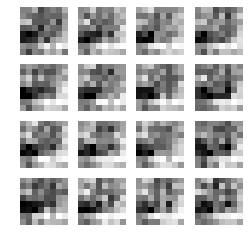

Time for epoch 97 is 1.546931266784668 sec


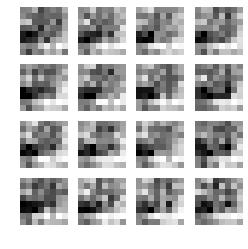

Time for epoch 98 is 1.5550436973571777 sec


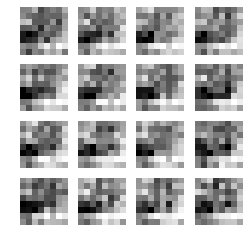

Time for epoch 99 is 1.5385758876800537 sec


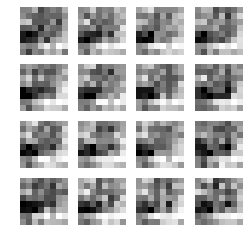

Time for epoch 100 is 1.784761905670166 sec


In [99]:
train(train_dataset)